In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import sparse, stats
from sklearn.model_selection import KFold

from pynba import possessions_from_file, use_blackontrans_style


use_blackontrans_style()
league = "nba"
years = [2018, 2019, 2020, 2021, 2022]
# years = [2016]
season_type = "Regular Season"

In [2]:
possessions = pd.concat([possessions_from_file(league, year, season_type) for year in years])
nba_player_ids = pd.read_csv("/home/jupyter/nba/data/NBA_Player_IDs.csv", encoding_errors="ignore")
player_id_mapping = {int(player_id): player_name for player_name, player_id in zip(nba_player_ids["NBAName"], nba_player_ids["NBAID"]) if not pd.isna(player_id)}

In [3]:
POSS_COLS = [
    "off_player0", "off_player1", "off_player2", "off_player3", "off_player4", 
    "def_player0", "def_player1", "def_player2", "def_player3", "def_player4",
    "points_scored", "possession_num"
]


def score_rapm(possessions, off_priors, def_priors):
    var = calc_variance(possessions)
    stints = calc_stints(possessions)
    player_ids = np.unique(stints.loc[:, [f"off_player{ind}" for ind in range(5)] + [f"def_player{ind}" for ind in range(5)]])
    X = calc_X(stints, player_ids)
    y = calc_y(stints)
    std = np.sqrt(var / stints["possession_num"])
    logpdfs = np.zeros((off_priors.shape[0], def_priors.shape[0]))
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train = X[train_index]
        stints_train = stints.iloc[train_index, :]
        XT_W_train = calc_XT_W(X_train, stints_train)
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        std_test = std[test_index]
        for off_ind, off_prior in enumerate(off_priors):
            for def_ind, def_prior in enumerate(def_priors):
                G_train = calc_G(X_train, var, off_prior, def_prior)
                A_train, b_train = calc_A_b(X_train, XT_W_train, G_train, y_train)
                x = solve_for_x(A_train, b_train)
                normalized_test_err = (y_test - X_test.dot(x)) / std_test
                logpdfs[off_ind, def_ind] += stats.norm.logpdf(normalized_test_err).sum()
    return logpdfs


def calc_rapm(possessions, off_prior, def_prior):
    var = calc_variance(possessions)
    stints = calc_stints(possessions)
    player_ids = np.unique(stints.loc[:, [f"off_player{ind}" for ind in range(5)] + [f"def_player{ind}" for ind in range(5)]])
    X = calc_X(stints, player_ids)
    XT_W = calc_XT_W(X, stints)
    G = calc_G(X, var, off_prior, def_prior)
    y = calc_y(stints)
    A, b = calc_A_b(X, XT_W, G, y)
    x = solve_for_x(A, b)
    x_off, x_def = x[:player_ids.shape[0]], x[player_ids.shape[0]:]
    names = [player_id_mapping.get(player_id, "n/a") for player_id in player_ids]
    return pd.DataFrame({"name": names, "off_rapm": x_off, "def_rapm": -x_def, "rapm": x_off - x_def}, index=player_ids)


def calc_stints(possessions):
    poss = possessions.loc[:, POSS_COLS]
    off_player_ids = poss[[f"off_player{ind}" for ind in range(5)]].to_numpy()
    off_player_ids.sort(1)
    poss["off_player_ids"] = [row.tobytes() for row in off_player_ids]
    def_player_ids = poss[[f"def_player{ind}" for ind in range(5)]].to_numpy()
    def_player_ids.sort(1)
    poss["def_player_ids"] = [row.tobytes() for row in def_player_ids]
    return poss.groupby(by=["off_player_ids", "def_player_ids"]).agg(
        {
            "off_player0": "first",
            "off_player1": "first",
            "off_player2": "first",
            "off_player3": "first",
            "off_player4": "first",
            "def_player0": "first",
            "def_player1": "first",
            "def_player2": "first",
            "def_player3": "first",
            "def_player4": "first",
            "points_scored": "sum",
            "possession_num": "count",
        }
    ).reset_index()


def calc_X(stints, player_ids):
    off_player_ids = stints.loc[:, [f"off_player{ind}" for ind in range(5)]]
    def_player_ids = stints.loc[:, [f"def_player{ind}" for ind in range(5)]]
    n_players = player_ids.shape[0]
    n_stints = stints.shape[0]

    X = sparse.lil_matrix((2 * n_players, n_stints))
    for ind, player_id in enumerate(player_ids):
        X[ind, :] = (player_id == off_player_ids).any(1)
        X[n_players + ind, :] = (player_id == def_player_ids).any(1)

    return X.T.tocsr().astype("float64")


def calc_y(stints):
    mu = stints["points_scored"].sum() / stints["possession_num"].sum()
    y = (stints["points_scored"] / stints["possession_num"] - mu) * 100
    return y.to_numpy().astype("float64")


def calc_XT_W(X, stints):
    w = stints["possession_num"].to_numpy().astype("float64").reshape(-1, 1)
    return X.multiply(w).T.tocsr()


def calc_G(X, var, off_prior, def_prior):
    n_players = X.shape[1] // 2
    data = np.array(([var / off_prior ** 2] * n_players) + ([var / def_prior ** 2] * n_players))
    offsets = np.array([0])
    shape = (X.shape[1], X.shape[1])
    return sparse.dia_matrix((data, offsets), shape=shape)


def calc_A_b(X, XT_W, G, y):
    A = XT_W.dot(X) + G
    b = XT_W.dot(y)
    return A, b


def calc_variance(possessions):
    counts = possessions["points_scored"].value_counts()
    p = counts / possessions.shape[0]
    eff = counts.index * 100
    return ((eff ** 2) * p).sum() - (eff * p).sum() ** 2


def solve_for_x(A, b):
    return sparse.linalg.spsolve(A, b)


def optimize(func, rounds, *args):
    bounds = np.array([[arg[0], arg[1]] for arg in args]).astype(float)
    x1 = bounds.mean(1)
    y1 = func(*x1)
    steps = np.diff(bounds, 1).reshape(-1) / 4
    history = [(tuple(x1), y1)]
    for _ in range(rounds):
        for ind, step in enumerate(steps):
            x0 = x1.copy()
            x0[ind] -= step
            y0 = func(*x0)
            history.append((tuple(x0), y0))
            if y0 > y1:
                bounds[ind, 1] = x1[ind]
                x1, y1 = x0, y0
                continue
            x2 = x1.copy()
            x2[ind] += step
            y2 = func(*x2)
            history.append((tuple(x2), y2))
            if y2 > y1:
                bounds[ind, 0] = x1[ind]
                x1, y1 = x2, y2
            else:
                bounds[ind, 0] = x0[ind]
                bounds[ind, 1] = x2[ind]
        steps /= 2
    return tuple(x1), y1, bounds, history


def optimize_rapm(possessions, rounds, off_range, def_range):
    var = calc_variance(possessions)
    stints = calc_stints(possessions)
    player_ids = np.unique(stints.loc[:, [f"off_player{ind}" for ind in range(5)] + [f"def_player{ind}" for ind in range(5)]])
    X = calc_X(stints, player_ids)
    y = calc_y(stints)
    std = np.sqrt(var / stints["possession_num"])
    def objective(off_prior, def_prior):
        return score_rapm(X, y, stints, std, var, off_prior, def_prior)
    return optimize(objective, rounds, off_range, def_range)


def score_rapm(X, y, stints, std, var, off_prior, def_prior):
    logpdf = 0
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train = X[train_index]
        stints_train = stints.iloc[train_index, :]
        XT_W_train = calc_XT_W(X_train, stints_train)
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        std_test = std[test_index]
        G_train = calc_G(X_train, var, off_prior, def_prior)
        A_train, b_train = calc_A_b(X_train, XT_W_train, G_train, y_train)
        x = solve_for_x(A_train, b_train)
        normalized_test_err = (y_test - X_test.dot(x)) / std_test
        logpdf += stats.norm.logpdf(normalized_test_err).sum()
    return logpdf

In [4]:
%load_ext pyinstrument

In [5]:
off_range = (1.4, 3)
def_range = (1.4, 3)
rounds = 4
%pyinstrument output = optimize_rapm(possessions, rounds, off_range, def_range)
output

_     ._   __/__   _ _  _  _ _/_   Recorded: 07:51:54  Samples:  10330
 /_//_/// /_\ / //_// / //_'/ //     Duration: 255.125   CPU time: 1720.514
/   _/                      v4.1.1

Program: /home/jupyter/.venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/jupyter/.local/share/jupyter/runtime/kernel-ba8e14ad-0114-49e5-8ec1-2f1e674244a6.json

255.125 <module>  ../../../tmp/ipykernel_456/266186798.py:2
`- 255.112 optimize_rapm  ../../../tmp/ipykernel_456/1799979028.py:155
   |- 234.654 optimize  ../../../tmp/ipykernel_456/1799979028.py:125
   |  `- 234.654 objective  ../../../tmp/ipykernel_456/1799979028.py:162
   |     `- 234.588 score_rapm  ../../../tmp/ipykernel_456/1799979028.py:167
   |        |- 191.577 solve_for_x  ../../../tmp/ipykernel_456/1799979028.py:121
   |        |  `- 191.577 spsolve  scipy/sparse/linalg/dsolve/linsolve.py:91
   |        |        [16 frames hidden]  scipy, <built-in>
   |        |           187.402 gssv  <built-in>:0
   |        |- 29.394 calc_A_b  ../../../tmp/ipykernel_456/1799979028.py:108
   |        |  `- 28.842 dot  scipy/sparse/base.py:346
   |        |        [20 frames hidden]  scipy, <built-in>, <__array_function_...
   |        |- 8.179 calc_XT_W  ../../../tmp/ipykernel_456/1799979028.py:95
   |        |  `- 4.264 multiply  scipy/sparse/compressed.py:365
   |        |        [27 frames hidden]  scipy, numpy, <built-in>, abc
   |        `- 2.778 __getitem__  pandas/core/indexing.py:918
   |              [83 frames hidden]  pandas, <built-in>, contextlib, numpy
   `- 18.155 calc_X  ../../../tmp/ipykernel_456/1799979028.py:75
      `- 15.034 __setitem__  scipy/sparse/lil.py:323
            [37 frames hidden]  scipy, <built-in>, <__array_function_...

((2.1500000000000004, 1.7500000000000002),
 -373307.85162206367,
 array([[2.1, 2.2],
        [1.7, 1.8]]),
 [((2.2, 2.2), -373314.49166221096),
  ((1.8000000000000003, 2.2), -373321.3577787366),
  ((2.6, 2.2), -373322.0175075667),
  ((2.2, 1.8000000000000003), -373308.0977561392),
  ((2.0, 1.8000000000000003), -373309.14657504315),
  ((2.4000000000000004, 1.8000000000000003), -373310.5387643732),
  ((2.2, 1.6000000000000003), -373308.818657729),
  ((2.2, 2.0000000000000004), -373310.2972731025),
  ((2.1, 1.8000000000000003), -373308.1098101235),
  ((2.3000000000000003, 1.8000000000000003), -373308.9521525352),
  ((2.2, 1.7000000000000002), -373308.0226573812),
  ((2.1500000000000004, 1.7000000000000002), -373307.9153868),
  ((2.1500000000000004, 1.6500000000000001), -373308.19650723325),
  ((2.1500000000000004, 1.7500000000000002), -373307.85162206367)])

In [6]:
off_prior = output[0][0]
def_prior = output[0][1]
%pyinstrument  rapm = calc_rapm(possessions, off_prior, def_prior)
rapm.describe()

_     ._   __/__   _ _  _  _ _/_   Recorded: 07:56:11  Samples:  5223
 /_//_/// /_\ / //_// / //_'/ //     Duration: 22.018    CPU time: 29.293
/   _/                      v4.1.1

Program: /home/jupyter/.venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/jupyter/.local/share/jupyter/runtime/kernel-ba8e14ad-0114-49e5-8ec1-2f1e674244a6.json

22.017 <module>  ../../../tmp/ipykernel_456/522187260.py:2
`- 22.008 calc_rapm  ../../../tmp/ipykernel_456/1799979028.py:34
   |- 18.488 calc_X  ../../../tmp/ipykernel_456/1799979028.py:75
   |  |- 15.319 __setitem__  scipy/sparse/lil.py:323
   |  |     [42 frames hidden]  scipy, <built-in>, <__array_function_...
   |  |        15.167 lil_fancy_set  <built-in>:0
   |  |- 1.764 any  pandas/core/generic.py:10520
   |  |     [198 frames hidden]  pandas, numpy, <built-in>
   |  |- 1.045 __getattr__  scipy/sparse/base.py:673
   |  |     [21 frames hidden]  scipy, <built-in>
   |  `- 0.270 __array_ufunc__  pandas/core/generic.py:2029
   |        [118 frames hidden]  pandas, <built-in>, numpy
   |- 2.014 calc_stints  ../../../tmp/ipykernel_456/1799979028.py:49
   |  |- 1.116 aggregate  pandas/core/groupby/generic.py:964
   |  |     [121 frames hidden]  pandas, <built-in>, <__array_function...
   |  |- 0.367 <listcomp>  ../../../tmp/ipykernel_456/1799979028.py:53
   |  `- 0.315 <listcomp>  ../../../tmp/ipykernel_456/1799979028.py:56
   `- 1.114 solve_for_x  ../../../tmp/ipykernel_456/1799979028.py:121
      `- 1.114 spsolve  scipy/sparse/linalg/dsolve/linsolve.py:91
            [7 frames hidden]  scipy, <built-in>

,off_rapm,def_rapm,rapm
count,963.000000,963.000000,963.000000
mean,-0.251340,0.166518,-0.084822
std,1.390722,0.967266,1.735574
min,-4.804169,-3.824582,-5.205578
25%,-1.028700,-0.317287,-1.011702
50%,-0.263891,0.061125,-0.161560
75%,0.324452,0.575736,0.643739
max,6.571922,4.642452,8.162528


In [7]:
rapm.sort_values(by="rapm", ascending=False).tail(20)

,name,off_rapm,def_rapm,rapm
202328,Greg Monroe,-2.511186,-1.127889,-3.639075
201573,Jerryd Bayless,-2.060903,-1.603449,-3.664351
1627775,Patrick McCaw,-2.599855,-1.068744,-3.668599
1627748,Thon Maker,-2.323273,-1.365213,-3.688486
1626143,Jahlil Okafor,-2.452976,-1.243805,-3.696781
1626144,Emmanuel Mudiay,-1.854918,-1.847647,-3.702565
1626184,Chasson Randle,-2.382039,-1.339661,-3.721700
203917,Nik Stauskas,-2.980972,-0.821984,-3.802956
1629647,Darius Bazley,-4.297873,0.360268,-3.937605
202732,DeAndre Liggins,-3.124750,-0.852451,-3.977200


In [8]:
rapm.sort_values(by="rapm", ascending=False).head(20)

,name,off_rapm,def_rapm,rapm
201939,Stephen Curry,6.571922,1.590606,8.162528
203507,Giannis Antetokounmpo,2.817330,4.642452,7.459782
101108,Chris Paul,3.883813,3.168886,7.052699
203081,Damian Lillard,5.963542,0.704749,6.668291
2544,LeBron James,5.356571,1.253975,6.610546
203999,Nikola Jokic,5.421035,1.161423,6.582458
202695,Kawhi Leonard,4.964804,1.361488,6.326292
203954,Joel Embiid,2.058690,3.984935,6.043626
202331,Paul George,2.618200,3.410418,6.028618
201950,Jrue Holiday,4.176530,1.833939,6.010469


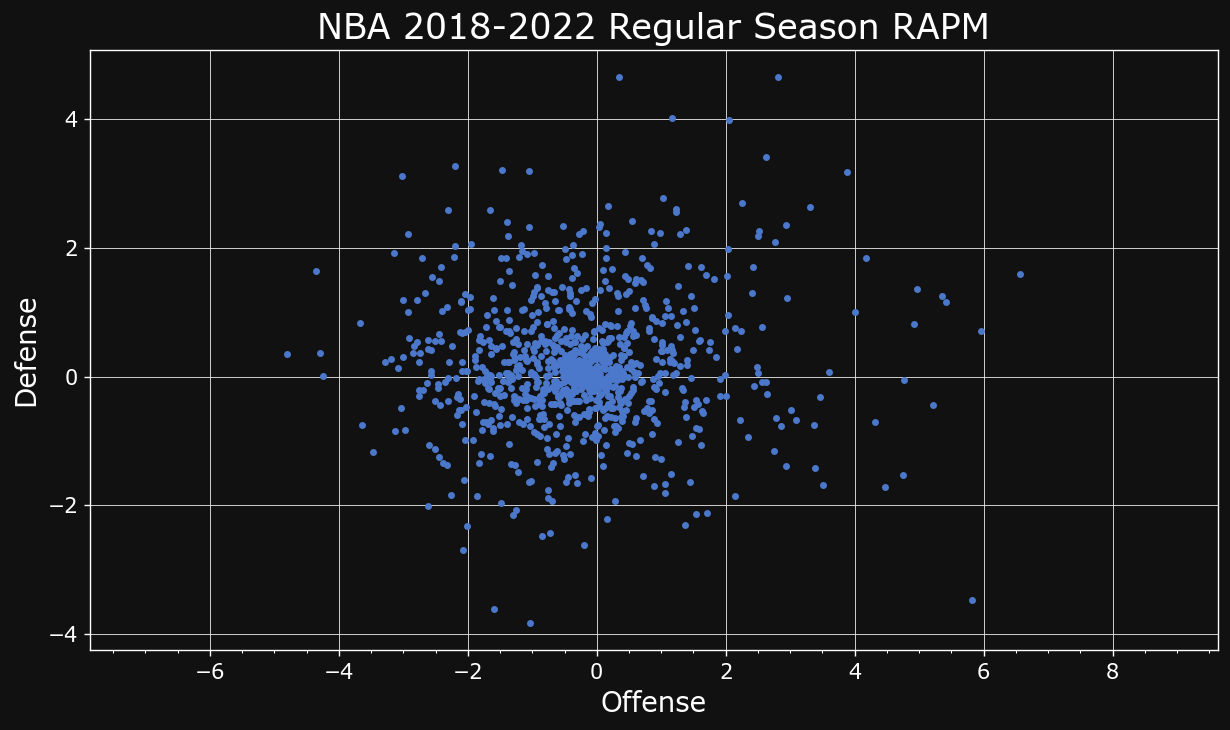

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(rapm["off_rapm"], rapm["def_rapm"], ".")
ax.set_xlabel("Offense")
ax.set_ylabel("Defense")
ax.set_title(f"{league.upper()} {min(years)}-{max(years)} {season_type} RAPM")
ax.axis("equal");